#  Non-Equilibrium Ionizations in the presence of background ionizations
The radiative cooling efficiencies of hot low-density gas are important quantities in the study of the diffuse interstellar and intergalactic medium. They determine the thermal and dynamical properties and evolution in a variety of astrophysical systems, ranging from local interstellar clouds to shocks in intergalactic filaments. Collisional ionizational equilibrium is often assumed where the cooling efficiencies depend only depend only on the gas temperature and metallicity. However, nonequlibrium ionization takes place when the hot gas cools radiatively below $\sim 10^6 K$. Rapid cooling is expected when



[Non-equilibrium ionisation and cooling of metal-enriched gas in the presence of a photo-ionisation background](https://noneq.strw.leidenuniv.nl/#noneqtables)
> Simulations of the formation of galaxies, as well as ionisation models used to interpret observations of quasar absorption lines, generally either assume ionisation equilibrium or ignore the presence of the extra-galactic background (EGB) radiation. We introduce a method to compute the non-equilibrium ionisation and cooling of diffuse gas exposed to the EGB. Our method iterates the ionisation states of the 11 elements that dominate the cooling (H, He, C, N, O, Ne, Si, Mg, S, Ca, & Fe) and uses tabulated ion-by-ion cooling and photo-heating efficiencies to update the temperature of the gas. Our reaction network includes radiative and di-electric recombination, collisional ionisation, photo-ionisation, Auger ionisation, and charge transfer. We verify that our method reproduces published results for collisional equilibrium, collisional non-equilibrium, and photo-ionised equilibrium. Non-equilibrium effects can become very important in cooling gas, particularly below 106 K. Photo-ionisation and non-equilibrium effects both tend to boost the degree of ionisation and to reduce cooling efficiencies. The effect of the EGB is larger for lower densities (i.e. higher ionisation parameters). Hence, photo-ionisation affects (equilibrium and non-equilibrium) cooling more under isochoric than under isobaric conditions. Non-equilibrium effects are smaller in the presence of the EGB and are thus overestimated when using collisional-only processes. The inclusion of the EGB alters the observational diagnostics of diffuse, metal-enriched gas (e.g. metal absorption lines probed in quasar sight lines) even more significantly than the cooling efficiencies. We argue that the cooling efficiency should be considered if ionisation models are used to infer physical conditions from observed line ratios, as the a priori probability of observing gas is lower if its cooling time is shorter. We provide on-line tables of ionisation fractions and cooling efficiencies, as well as other data, for equilibrium and non-equilibrium scenarios, and both with and without an EGB. Cooling efficiencies and diagnostics of the physical state of diffuse gas can become highly inaccurate if ionisation equilibrium is assumed or if the existence of the ionising background is ignored.





In [2]:
import os

os.environ["XUVTOP"] = "/home/kwoksun2/data/dengo-merge/CHIANTI"
from dengo.reaction_classes import chianti_rate
from dengo.reaction_classes import ion_photoionization_rate

from dengo.chemical_network import (
    ChemicalNetwork,
    species_registry,
    reaction_registry,
    cooling_registry,
)
import ChiantiPy.core as ch
import numpy as np
import matplotlib.pyplot as plt

 ChiantiPy version 0.12.0 
 found PyQt5 widgets
 using PyQt5 widgets


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/tools/data.py:71: UserWarning: klgfb files are not present: 
  it will not be possible to use the freeBound continuum method
  warnings.warn('klgfb files are not present: \n  it will not be possible to use the freeBound continuum method')
/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")


## H, He, O non-equilibrium chemistry

H, He, C, N, O, Ne, Si, Mg, S, Ca, & Fe are the dominant elements in the cooling of diffuse gases.
To begin with, we outlined the steps to implement all the non-equilibrium chemistry involved for hydrogen them in `dengo`. And then we will outline how you could extend them to other species of interest with the rate tables from `Dengo`. Primarily, photo-ioniation, collisional ioniziation, recombinations dictates how the ioinization levels change under both the influence of temperature and the radiation background. 

## Ionization and Recombinations
The recombination, and ionization rates can be obtained from `Chiantipy`.

For Hydrogen, 
$$
\mathrm{H + e^- \rightarrow H^+ + 2 e^-} \\
\mathrm{H^+ + e^- \rightarrow H}
$$

They can be retrieved through `chianty.ion.ionizRate` and `chianty.ion.RecombRate`. 

In [3]:
from dengo.reaction_classes import AtomicSpecies

HI = AtomicSpecies("H", free_electrons=0)
HII = AtomicSpecies("H", free_electrons=1)
de = species_registry["de"]

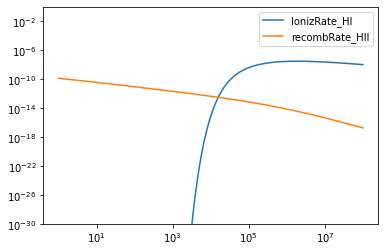

In [18]:
ion_by_ion = ChemicalNetwork()
ion_by_ion.init_temperature((1e0, 1e8))
ion_by_ion.init_redshift((1e-6, 15.0))

ion_HI = ch.ion("h_1", temperature=ion_by_ion.T)
ion_HI.ionizRate()
IonizRate_HI = ion_HI.IonizRate["rate"]

ion_HII = ch.ion("h_2", temperature=ion_by_ion.T)
ion_HII.recombRate()
recombRate_HII = ion_HII.RecombRate["rate"]

plt.loglog(network.T, IonizRate_HI, label="IonizRate_HI")
plt.loglog(network.T, recombRate_HII, label="recombRate_HII")
plt.ylim(1e-30, 1e0)
plt.legend()

## Mapping Chianti Rate to Reactions
This can be done straightforwardly with `dengo.ion_by_ion.chianti_rate`.
The function takes atom_name, recombined species, original species, and the ionized species to be input. Once `chianti_rate` is called, reactions are automatically registered in `reaction_registry`.

In [19]:
?chianti_rate

Signature: chianti_rate(atom_name, sm1, s, sp1)
Docstring:
Create Collisional Ionization and Recombination reactions from the ChiantiPy

Parameters
----------
atom_name: str
    the name of the atom of interest
sm1: str
    the name of the recombined species
s: str
    the name of the original species
sp1: str
    the name of the ionized species

Returns
-------
new_rates: List[Str]
    the list of reactions names added
File:      /mnt/gv0/homes/kwoksun2/dengo-merge/dengo/reaction_classes.py
Type:      function


In [20]:
# This would create the recombination
(recomb_H,) = chianti_rate("H", None, HI, HII)
# Collisional Ionization
(ioniz_H,) = chianti_rate("H", HI, HII, None)

rxn_name = [recomb_H, ioniz_H]
print(rxn_name)

['H_1_i', 'H_2_r']


In [21]:
reaction_registry

{'H_1_i': H_1_i : 1*H_1 + 1*de => 1*H_2 + 2*de,
 'H_2_r': H_2_r : 1*H_2 + 1*de => 1*H_1}

In [23]:
ion_by_ion.add_reaction(recomb_H)
ion_by_ion.add_reaction(ioniz_H)

Adding reaction: H_1_i : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: H_2_r : 1*H_2 + 1*de => 1*H_1


here `H_1_i` corresponds to the collionsional ionization of neural hydrogen atom, while `H_2_r` refers to the recombination of the ionizied hydrogen with electrons.

## PhotoIonization

Unlike recombination and ionization, photoioinization depends on the background radiation and the cross section. To this end, `Dengo` comes up with precompiled tables from [Non-equilibrium ionisation and cooling of metal-enriched gas in the presence of a photo-ionisation background](https://noneq.strw.leidenuniv.nl/#noneqtables), and these are stored under `input/photoionization`. This photoionization rates are calculated using the extra galactic background from [Haardt & Madau(2012)](http://adsabs.harvard.edu/abs/2009MNRAS.393...99W) by[Oppenheimer and Schaye](https://arxiv.org/pdf/1302.5710.pdf). $\mathrm{H, He, C, N, O, Ne, Si, Mg, S, Ca, Fe}$ are the dominant species and their respective photoionization rates are provided alongside `Dengo`, under `input/photoionization/{species_name}_ion_by_ion_photoionization_HM12.h5`. These reactions can be recognized and automatically added to the `reaction_registry` with `dengo.reaction_classes.ion_photoionization_rate`. Since `H^+` cannot be further ionized, the function returns an empty list. The reaction name that depicts the photonization of hydrogen atom is given by `H_1_pi`.

In [33]:
(photo_HI,) = dengo.reaction_classes.ion_photoionization_rate(HI)
photo_HII = dengo.reaction_classes.ion_photoionization_rate(HII)
print(photo_HI, photo_HII)

H_1_pi []


## Photoionization Heating

Photo-heating efficiency of a species $x_i$ is given by
$$
\epsilon_{x_i} = \int_{\nu_{0,x_i}}^\infty \frac{4\pi J_\nu}{h\nu} \sigma_{x_i} (\nu) h(\nu - \nu_{0,x_i}) d\nu
$$
where $J_\nu$ is the EGB radiation field HM12, $\sigma_{x_i}$ is the photo-ionization cross-section of species $x_i$. $\nu_{0,x_i}$ is the ground state energy of the (ionized) atom. `Dengo` handles it internally with `dengo.reaction_classes.ion_photoheating_rate` and registered it in `cooling_registry`. To go from photo-heating efficiency to heating rate one has to multiply it by the number density of the species $x_i$. This can be obtained from the examining the equation attribute from cooling_action.

In [76]:
(photoheat_HI,) = dengo.reaction_classes.ion_photoheating_rate(HI)

In [77]:
cooling_registry

{'H_1_ph': <dengo.reaction_classes.CoolingAction at 0x7f984777c550>,
 'H_2_ph': <dengo.reaction_classes.CoolingAction at 0x7f9850a0a1c0>,
 'H_1_c': <dengo.reaction_classes.CoolingAction at 0x7f9850472340>,
 'H_2_c': <dengo.reaction_classes.CoolingAction at 0x7f9850472f70>}

In [78]:
cooling_registry["H_1_ph"].equation

H_1_ph_H_1_ph[i]*H_1

Text(0, 0.5, 'Rates ($\\rm erg/s $}')

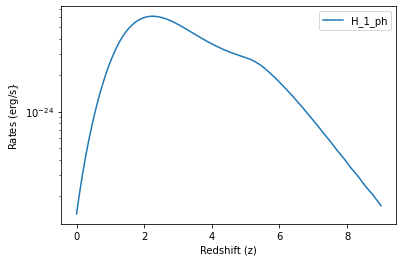

In [81]:
plt.semilogy(
    ion_by_ion.z,
    cooling_registry["H_1_ph"].tables["H_1_ph"](ion_by_ion),
    label="H_1_ph",
)
plt.legend()
plt.xlabel("Redshift (z)")
plt.ylabel(r"Rates ($\rm erg/s $}")

# Radiative Cooling

Ion-by-Ion cooling includes many different process including include collisional excitations followed by line emission, recombinations with ions, collisional ionizations, and thermal bremsstrahlung. The electron cooling efficiency includes the removal of electron kinetic energy via recombinations with ions, collisional ionizations, collisional excitations followed by prompt line emissions, and thermal bremsstrahlung.
For a detailed discussion of the physics involved, we refer readers to [Gnat and Ferland 2012](https://iopscience.iop.org/article/10.1088/0067-0049/199/1/20), [Osterbrock & Ferland](https://ui.adsabs.harvard.edu/abs/2006agna.book.....O). Ion-by-ion cooling efficiencies can be multiplied by $n_{x_i}$ and $n_e$ to obtain the volumetric cooling rate. This is handled by `dengo.reaction_classes.ion_cooling_rate` and registered automatically by `dengo` in cooling registry.

In [82]:
ion_cool_HI = dengo.reaction_classes.ion_cooling_rate(HI, "H")

In [83]:
ion_cool_HII = dengo.reaction_classes.ion_cooling_rate(HII, "H")

In [84]:
cooling_registry

{'H_1_ph': <dengo.reaction_classes.CoolingAction at 0x7f984777c550>,
 'H_2_ph': <dengo.reaction_classes.CoolingAction at 0x7f9850a0a1c0>,
 'H_1_c': <dengo.reaction_classes.CoolingAction at 0x7f98476ee910>,
 'H_2_c': <dengo.reaction_classes.CoolingAction at 0x7f98476e8be0>}

In [85]:
cooling_registry["H_1_c"].equation

-H_1_c_H_1_c[i]*H_1*de

In [86]:
cooling_registry["H_2_c"].equation

-H_2_c_H_2_c[i]*H_2*de

Text(0, 0.5, 'Rates ($\\rm erg/s cm^3$}')

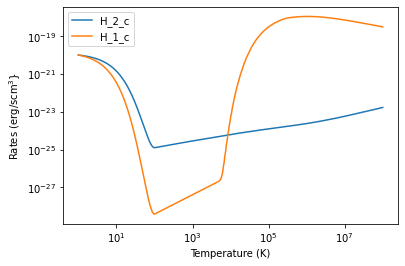

In [87]:
plt.loglog(
    ion_by_ion.T, cooling_registry["H_2_c"].tables["H_2_c"](ion_by_ion.T), label="H_2_c"
)
plt.loglog(
    ion_by_ion.T, cooling_registry["H_1_c"].tables["H_1_c"](ion_by_ion.T), label="H_1_c"
)
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel(r"Rates ($\rm erg/s cm^3$}")

## Summing it all up
Ionization, recombination, photo-ionization give rises to transitions between ionization states. Photo-heating, and ion-by-ion cooling modifies the thermal energy of the system. In the above we demonstrated that it can be accounted for by adding each one of them by hand. This can grow out of hand as the number of ionization state is enormous. Dengo provide a more straightforward implementation with `dengo.ion_by_ion setup_ionization`. In the next chapter, we assemble them together and evolve a sample case with $\mathrm{H, He, O}$.